# Password visualizer algorithm experiments

We want to develop a password visualizer which indicates the user that his or her password may be wrong before it's acutally sent over and checked (which can take considerable time).

## Background

As far as I know, Lotus Notes (or IBM Notes today) has similar functionality, but I haven't satisfied with it since it's just a combination of images which is not quite memorable.
I think it should be more visually distinguishable, easy to memorize representation which has many more combinations (thus less likely to collide).
So I think it's a good exercise to develop an algorithm for the purpose.

## Requirements

The requirements for this algorithm:

* It should not be able to infer the password from the representation, otherwise it might as well revealing the plain password.
* Even single character difference should totally change the representation so that the user can easily tell.
* The visualization should have prominent features that the user can easily remember.

## Using hashes

We want the password to be completely encrypted, infused into the source of the visualization algorithm.
Also, we want the visualization to be completely different even if a bit in the password has changed.
For this purpose, a hash function is a good choice.

A hash function takes arbitrary data (in this case, password) and spits a fixed length binary data, which can be used as the source of the visualization.
We don't need to use all the bits in the hash data, since a hash function should evenly distribute the influence of any portion of the input into the output data.

In this demonstration, we use SHA1 hash algorithm, but in real systems, the implementor should consider more secure, modern and robust algorithm.

## Security consideration

Sometimes, the password checking is intentionally designed to take time, so an attacker will need more time to brute-force attack to crack the password.
Showing the potential correctness of a password earlier may undermine the security by this intentional delay, if the visualization is somehow revealed to the attackers.
It means the visualization is sensitive information and should not be transferred by wire or something.

Also, if the password is stored as a hash in the authentication database, it should have a different representation as the source of visualization we are discussing.
If otherwise, the attacker can easily reconstruct the hashing algorithm by collecting password and hash pairs.
It means the visualization should have a different salt to append to the password.

## The algorithm

We use polygonal lines because they are easy to implement, easy to make variations and visually distinguishable.

In [1]:
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib.pyplot as plt
import numpy.polynomial.hermite
%matplotlib inline

In [2]:
import hashlib

In [117]:
# Test the usage of hash function
m = hashlib.sha1()
m.update(b'update')
m.digest()

b'\n%\xbaY\x911k\xdd\xa4\xa9\xb3\xab\xce\xe2\x10`\x16\xdf(\xa0'

In [115]:
def primes(nn):
    n = nn
    primfac = []
    thieve = np.ones(n, dtype=bool)
    d = 2
    def shake_thieve(d):
        for ni in range(1, n):
            if len(thieve) <= d * ni:
                break
            thieve[d * ni] = False
    while d*d <= n:
        while (n % d) == 0:
            primfac.append(d)  # supposing you want multiple factors repeated
            shake_thieve(d)
            n //= d
        d += 1
    if n > 1:
        primfac.append(n)
        shake_thieve(n)
    indices = [i for i in range(1,len(thieve)) if thieve[i]]
    return primfac, indices

In [113]:
for i in range(10,17):
    print('{}: {}'.format(i, primes(i)))

10: ([2, 5], [1, 3, 7, 9])
11: ([11], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
12: ([2, 2, 3], [1, 5, 7, 9, 11])
13: ([13], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
14: ([2, 7], [1, 3, 5, 9, 11, 13])
15: ([3, 5], [1, 2, 4, 7, 8, 11, 13, 14])
16: ([2, 2, 2, 2], [1, 3, 5, 7, 9, 11, 13, 15])


In [84]:
def plothash(hashall):
    debug = []
    for n in range(3):
        hash = hashall[n*3:n*3+5]
        phases = (hash[0] & 0xf) + 3
        factors = primes(phases)[1]
        skips = factors[((hash[0] >> 4) & 0xf) % len(factors)]
        r = .5 * (hash[4] / 255.) + .25
        debug.append([phases, skips, r])
        x = np.zeros((phases+1,2))
        for i in range(phases+1):
            phase = i * skips / phases * 2 * np.pi
            x[i,0] = r * np.cos(phase)
            x[i,1] = r * np.sin(phase)
        plt.plot(x[:,0], x[:,1])
        plt.xlim([-.75,.75])
        plt.ylim([-.75,.75])
        plt.axis('off')
    print(debug)

[[14, 5, 0.41470588235294115], [11, 2, 0.4343137254901961], [6, 1, 0.42254901960784313]]
[[13, 2, 0.4343137254901961], [17, 15, 0.2754901960784314], [14, 11, 0.6245098039215686]]
[[13, 3, 0.6441176470588235], [8, 7, 0.6029411764705883], [18, 1, 0.7068627450980391]]
[[3, 2, 0.5323529411764706], [10, 1, 0.6147058823529412], [4, 3, 0.36568627450980395]]
[[16, 7, 0.4950980392156863], [3, 2, 0.35980392156862745], [17, 12, 0.669607843137255]]
[[18, 5, 0.4441176470588235], [16, 5, 0.3931372549019608], [8, 5, 0.5519607843137255]]
[[17, 5, 0.7264705882352941], [12, 1, 0.5892156862745098], [8, 1, 0.5754901960784313]]
[[8, 7, 0.4872549019607843], [14, 5, 0.3990196078431373], [3, 2, 0.40098039215686276]]
[[13, 2, 0.47352941176470587], [6, 5, 0.2735294117647059], [17, 12, 0.3029411764705882]]


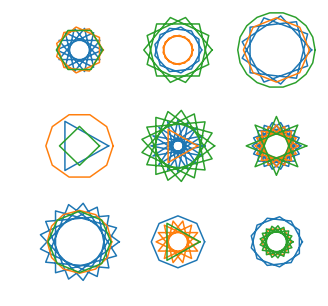

In [123]:

tests = [b'serious', b'', b'hello world',
         b'passwd', b'111111', b'111112',
         b'aloha', b'1', b'something']

plt.figure(figsize=(5,5))
for r in range(3):
    for c in range(3):
        plt.subplot(3, 3, r * 3 + c + 1)
        plothash(hashlib.sha1(tests[r * 3 + c]).digest())
